## Final Project Submission

Please fill out:
* Student name: Ryan McArthur
* Student pace: self paced / part time / full time FULL TIME
* Scheduled project review date/time: 
* Instructor name: James Irving
* Blog post URL:


# Introduction

Our goal in this investigation is to construct a model that most accurately predicts the sale price of a home in Kings County, Washington. We are completing this investigation in order to better inform prospective home sellers in order for them to obtain the highest possible price for their home. In doing so, we are searching for predictors from our dataset that maximize price. 

First, we will investigate the raw relationships between our predictors by constructing a model using data that has been left alone as much as possible. In this phase, the only tasks to be considered are cleaning data, dealing with categorical values, calculating multicollinearity, and finally modeling the resulting data. 

Next, in order to most accurately predict our prospective home sellers' property, our model needs to be refined for a highest possible R^2 value. At this point, we will further manipulate our data by removing outliers, performing data normality checks and transformations, and training our model for the best fit. 

Finally, we will construct a model that can be used more simply, for prospective home owners that are looking for an expedient method of finding their homes predicted price. In this stage, columns will be removed from our model that would be difficult for homeowners to find readily. This stage of our investigation focuses on ease of interpretation, since it would be homeowners running this model on an external interface, not data scientists. 

In [330]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats

df = pd.read_csv('kc_house_data.csv')

target = 'price'

# Section 0: Data Scope 

In order to have any hope of constructing a model that is interpretable, we must understand where our data comes from, what it measures exactly, and what implications these considerations may have on our investigation. 

The time frame for data collection is between 2014 and 2015. We do not have to worry about historical trends in home prices or inflation due to the small sample time frame. 

Our data is collected from a single county, Kings County, in Washington State. With this in mind, the columns 'Lat' and 'Long', which describe the property's latitude and longitude, respectively, may not be as informative as we might have first thought, because the variations in the latitude and longitude in a single county is negligible. In this case, zipcode would be a better predictor when looking at the location of the property. 

# Section 1: Cleaning Data

## Handling Datatypes

In [331]:
#checking datatypes of all columns

df.dtypes

#we will need to alter the date and sqft_basement columns

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

### Date

In [332]:
#slicing the dates to remove forward slashes

sliced_dates = []
for i in df['date']:
    string = ''
    splits = i.split('/')
    string = string.join(splits)
    sliced_dates.append(string)
df['date'] = sliced_dates    
        
#converting from object to datetime
df['date'] = pd.to_datetime(df['date'], format = '%m%d%Y')

df['date']

0       2014-10-13
1       2014-12-09
2       2015-02-25
3       2014-12-09
4       2015-02-18
           ...    
21592   2014-05-21
21593   2015-02-23
21594   2014-06-23
21595   2015-11-06
21596   2014-10-15
Name: date, Length: 21597, dtype: datetime64[ns]

### Sqft_Basement

In [333]:
# sqft_basement needs to be converted to either a float or int

df.sqft_basement.value_counts(dropna = False)

#sqft_basement values have a possibility of being '?', which we must asssume means there is not a basement.
#We will convert these '?' instances to 0.0

df['sqft_basement'] = df['sqft_basement'].replace('?', '0.0')

# now we are able to convert the datatype from object to float
df['sqft_basement'] = df['sqft_basement'].astype(float)

df['sqft_basement']

0          0.0
1        400.0
2          0.0
3        910.0
4          0.0
         ...  
21592      0.0
21593      0.0
21594      0.0
21595      0.0
21596      0.0
Name: sqft_basement, Length: 21597, dtype: float64

In [334]:
# double checking our datatype conversions

df.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront              float64
view                    float64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement           float64
yr_built                  int64
yr_renovated            float64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

## Handling Missing Values

In [335]:
# Checking all columns for missing values

df.columns[df.isnull().any()]

#our waterfront, view, and yr_renovated columns all have missing values    

Index(['waterfront', 'view', 'yr_renovated'], dtype='object')

### Waterfront

In [336]:
#defining placeholder column

col = 'waterfront'

df[col] = df[col].fillna(0.0)

df[col].value_counts(dropna = False)



0.0    21451
1.0      146
Name: waterfront, dtype: int64

### View

In [337]:
col = 'view'

df[col] = df[col].fillna(0.0)
df[col].value_counts(dropna = False)

0.0    19485
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

### Yr_renovated

In [338]:
col = 'yr_renovated'

df[col] = df[col].fillna(0.0)
df[col].value_counts(dropna = False)

0.0       20853
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

# Section 2: Exploring Data

## Handling Column Context

### Yr_renovated

The column 'yr_renovated' is problematic. Values are recorded as either the year that the home was renovated, or if the home was never renovated, 0.0. The issue with this is that our model would interpret the home as being renovated in the year 0000! We need to alter the data in order for our model to correctly interpret home renovation information. Instead of having a column with the year that a home was renovated, we can instead build a column that records the time since the most recent construction on the home. This should correclty reflect home renovations, while not disproportionately affecting homes that had not been renovated. 

In [339]:
yrs_since_construction = []


for i in range(len(df.yr_built)):

    if df['yr_renovated'][i] > 0.0:
        yrs_since_construction.append(2015 - df['yr_renovated'][i])
    
    else:
        yrs_since_construction.append(2015 - df['yr_built'][i])

        
df['yrs_since_construction'] = yrs_since_construction

#now to drop the column that has been reconceptualized

df = df.drop('yr_renovated', axis = 1)


## Classifying Categorical Columns

In [340]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'yrs_since_construction'],
      dtype='object')

In [341]:
# visualizing distributions of our columns

#pd.plotting.scatter_matrix(df, figsize = (20, 20))
#plt.show()

#### Upon inspection, the following columns may be categorical:
- Waterfront
- View
- Condition
- Grade

#### And the following is logically categorical:
- Zipcode


### Verifying Categorical Classification

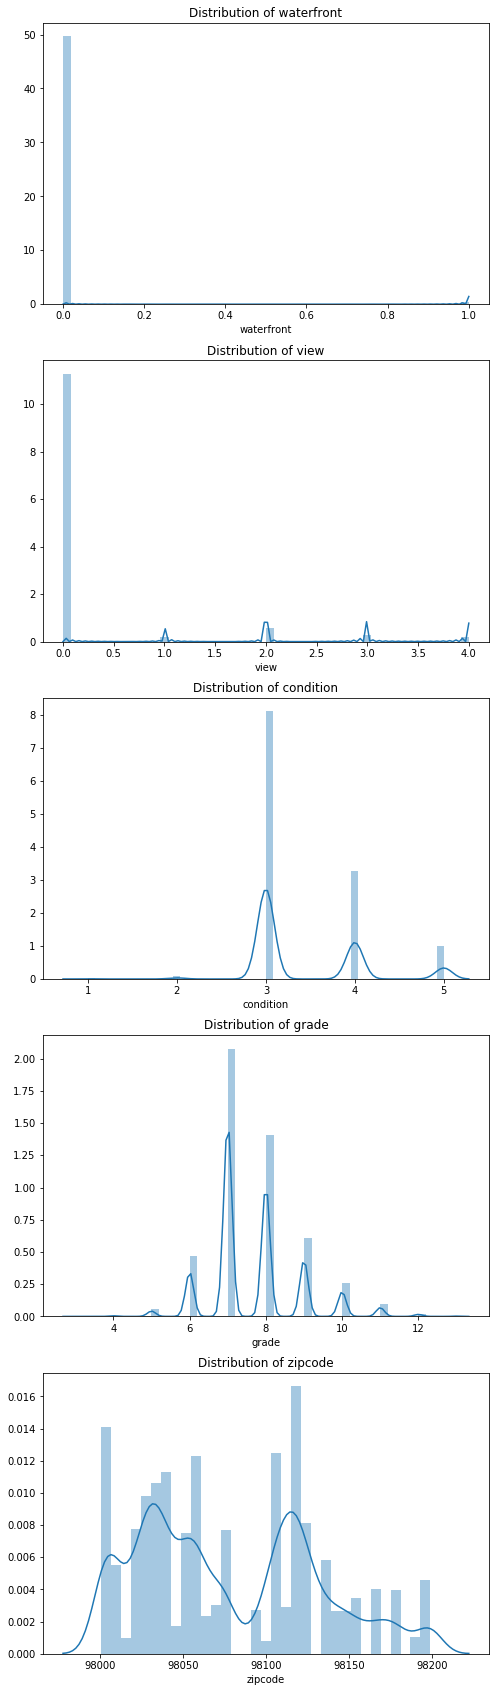

In [342]:
# visualizing distributions of all our possible categorical columns

cat_cols = ['waterfront', 'view', 'condition', 'grade', 'zipcode']

fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize = (8, 30))

for i, col in enumerate(cat_cols):
    sns.distplot(df[col], ax = axes[i]).set_title('Distribution of '+col)

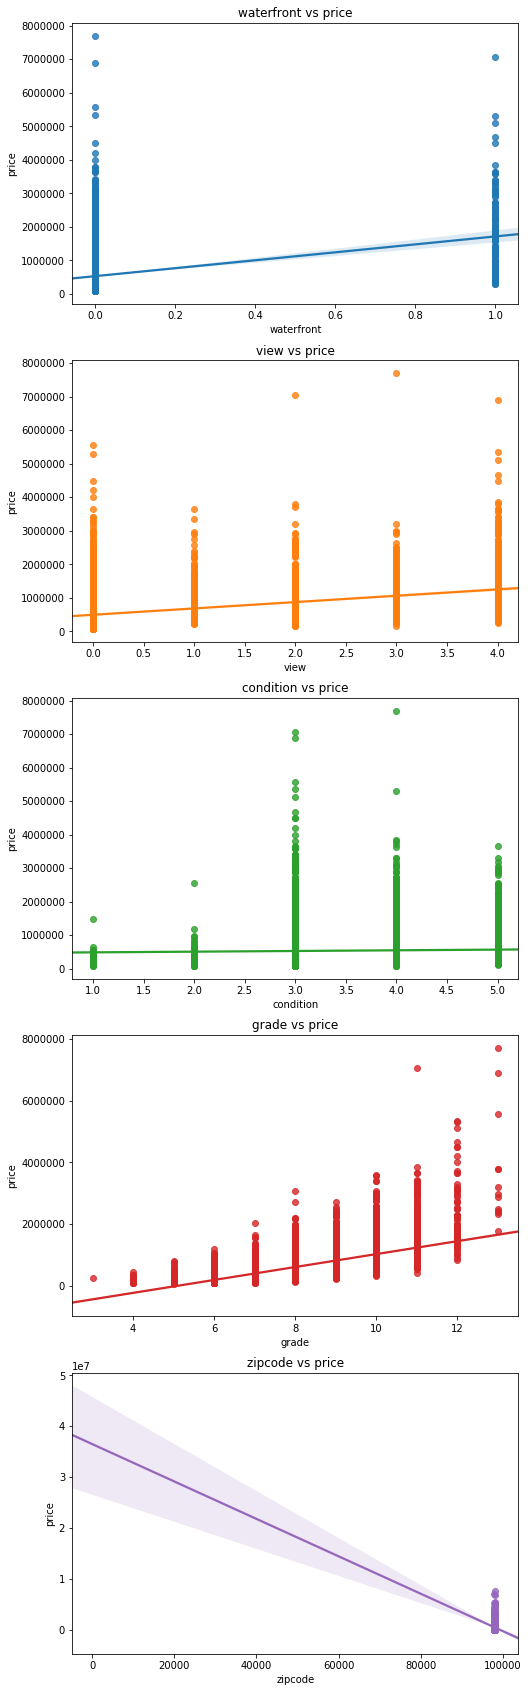

In [343]:
# visualizing the linear relationships of our categorical columns vs price

fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize = (8, 30))

for i, col in enumerate(cat_cols):
    sns.regplot(data = df, ax = axes[i], y = target, x = col).set_title(col + ' vs ' + target)

From these linear visualizations, we can confirm that all of these columns meet the requirements to be considered categorical except for 'grade'. As we will see in the 'Multicollinearity' section of this investigation, 'grade' is multicollinear with other columns, leading us with the options of either making 'grade' a categorical column now, or removing 'grade' in our model altogether. Removing columns is not what we want to do in this preliminary stage of the investigation, so we will make all of the above columns into categorical predictors. 

### Further Datatype Handling

To convert these columns to categorical predictors, we need to change the datatypes from floats or integers to strings. 

In [344]:
# we do not need to alter 'waterfront' because this column is already recorded as either 0 or 1, which is the end goal
# of one-hot-encoding. 

cat_cols = ['view', 'condition', 'grade', 'zipcode']
df_tb_encoded = df.copy()
for i in cat_cols:
    df_tb_encoded[i] = df_tb_encoded[i].astype(str)

df_ohe = pd.get_dummies(df_tb_encoded, columns = cat_cols)
df_ohe



,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,1180,...,0,0,0,0,0,0,1,0,0,0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,2170,...,0,0,0,0,0,0,0,0,0,0
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,770,...,0,0,0,0,0,0,0,0,0,0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,1050,...,0,0,0,0,0,0,0,0,0,0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,1680,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0.0,1530,...,0,0,0,0,0,0,0,0,0,0
21593,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0.0,2310,...,1,0,0,0,0,0,0,0,0,0
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0.0,1020,...,0,0,0,0,0,0,0,0,0,0
21595,291310100,2015-11-06,400000.0,3,2.50,1600,2388,2.0,0.0,1600,...,0,0,0,0,0,0,0,0,0,0


In [345]:
def fix_ohe_colnames(df_ohe):
    df_ohe = df_ohe.copy()
    new_col_names = list(map(lambda x: x.replace('.','').replace(' ',''),df_ohe.columns))
    new_col_names = list(map(lambda x: x.replace('(','').replace(')',''),new_col_names))
    new_col_names= list(map(lambda x: x.replace('&',''),new_col_names))
    df_ohe.columns = new_col_names
    return df_ohe

df_ohe = fix_ohe_colnames(df_ohe)

## Multicollinearity Checks

### Using .corr and Heatmaps

In [346]:
# finding correlations that are greater than 0.70

abs(df.corr()>0.70)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_construction
id,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,True,False,True,True,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False
sqft_lot,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
floors,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [347]:
# in order to return list of multicollinear columns:

df_corr = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))

df_corr.set_index(['pairs'], inplace = True)

df_corr.drop(columns = ['level_1', 'level_0'], inplace = True)

df_corr.columns = ['cc']

df_corr.drop_duplicates(inplace = True)

# constructing the correlation dataframe
df_corr[(df_corr.cc>0.70) & (df_corr.cc<1)]

,cc
pairs,
"(yrs_since_construction, yr_built)",0.926406
"(sqft_living, sqft_above)",0.876448
"(grade, sqft_living)",0.762779
"(sqft_living15, sqft_living)",0.756402
"(grade, sqft_above)",0.756073
"(bathrooms, sqft_living)",0.755758
"(sqft_above, sqft_living15)",0.731767
"(sqft_lot15, sqft_lot)",0.718204
"(grade, sqft_living15)",0.713867


'Grade' was classified as a categorical predictor based off of its correlation with other predictors. Otherwise, we would have had to drop this column as well. 

From these correlations, we will be removing the following columns for our initial model: 
- yr_built
- sqft_above
- sqft_living15
- sqft_lot15


# Section 3: Raw Modeling

## Model Construction

In [348]:
def model_maker(df_ohe, target = 'price', drop_cols=[]):
    df_mod = df_ohe.copy()
    
    for column in drop_cols:
        if column in df_mod.columns:
            df_mod.drop(columns = column, inplace = True)
    
    features = '+'.join(df_mod.drop(columns = target).columns)
    formula = target + '~' + features
    
    model = smf.ols(formula, df_mod).fit()
    return model

In [349]:
def model_measures(model, y_true = None):
    
    display(model.summary())
    
    residuals = model.resid
    
    fig, ax = plt.subplots(ncols = 2, figsize = (10, 5))
    
    sm.graphics.qqplot(residuals, stats.distributions.norm, fit = True
                      , line = '45', ax = ax[0])
    ax[0].set_title('QQ Plot')
    
    if y_true == None:
        xs = np.linspace(0, len(residuals), len(residuals))
        xlabel = 'Row in Dataset'
        font_dict = dict(rotation = 0)
    else:
        xs = y_true
        xlabel = 'True Target Values'
        x_rot = 0
        font_dict = dict(rotation = 45, ha = 'right')
    ax[1].scatter(x = xs, y = residuals)
    ax[1].axhline(0, color = 'k', zorder = 1)
    
    ax[1].set(ylabel = 'Residuals', title = "Homeoskedasticity Measure",
             xlabel = xlabel)
    
    plt.tight_layout()
    plt.show()

In [350]:
#we need to be sure to exclude both the 'date' column and 'id' column
df_ohe = df_ohe.drop('date', axis = 1)

In [351]:
df_ohe = df_ohe.drop('id', axis = 1)

In [352]:
raw_model = model_maker(df_ohe, drop_cols = ['yr_built', 'sqft_above', 'sqft_living15', 'sqft_lot15'])

## Model Evaluation

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     1110.
Date:                Wed, 02 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:55:11   Log-Likelihood:            -2.8803e+05
No. Observations:               21597   AIC:                         5.763e+05
Df Residuals:                   21499   BIC:                         5.770e+05
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -2.364e+07   3.82e+06     -6.194      0.000   -3.11e+07   -1.62e+07
bedrooms               -1.201e+04   1467.884     -8.181      0.000   -1.49e+04   -9131.408
bathrooms               2.167e+04   2470.284      8.770      0.000    1.68e+04    2.65e+04
sqft_living              173.7504      2.722     63.830      0.000     168.415     179.086
sqft_lot                   0.1948      0.027      7.121      0.000       0.141       0.248
floors                 -3.323e+04   2942.651    -11.292      0.000    -3.9e+04   -2.75e+04
waterfront              6.026e+05   1.55e+04     38.901      0.000    5.72e+05    6.33e+05
sqft_basement            -52.4772      3.390    -15.480      0.000     -59.122     -45.832
lat                     2.268e+05   5.93e+04      3.822      0.000     1.1e+05    3.43e+05
long                   -2.081e+05   4.26e+04     -4.886      0.000   -2.92e+05   -1.25e+05
yrs_since_construction    70.6882     59.107      1.196      0.232     -45.166     186.542
view_00                -4.856e+06   7.63e+05     -6.361      0.000   -6.35e+06   -3.36e+06
view_10                -4.764e+06   7.63e+05     -6.240      0.000   -6.26e+06   -3.27e+06
view_20                -4.782e+06   7.63e+05     -6.264      0.000   -6.28e+06   -3.29e+06
view_30                -4.694e+06   7.63e+05     -6.149      0.000   -6.19e+06    -3.2e+06
view_40                -4.547e+06   7.64e+05     -5.956      0.000   -6.04e+06   -3.05e+06
condition_1            -4.822e+06   7.64e+05     -6.313      0.000   -6.32e+06   -3.32e+06
condition_2            -4.737e+06   7.64e+05     -6.204      0.000   -6.23e+06   -3.24e+06
condition_3            -4.726e+06   7.63e+05     -6.191      0.000   -6.22e+06   -3.23e+06
condition_4            -4.702e+06   7.63e+05     -6.159      0.000    -6.2e+06   -3.21e+06
condition_5            -4.657e+06   7.63e+05     -6.100      0.000   -6.15e+06   -3.16e+06
grade_10               -2.268e+06   3.47e+05     -6.528      0.000   -2.95e+06   -1.59e+06
grade_11               -2.072e+06   3.48e+05     -5.960      0.000   -2.75e+06   -1.39e+06
grade_12               -1.667e+06   3.48e+05     -4.798      0.000   -2.35e+06   -9.86e+05
grade_13               -5.653e+05    3.5e+05     -1.617      0.106   -1.25e+06     1.2e+05
grade_3                -2.324e+06   3.73e+05     -6.227      0.000   -3.06e+06   -1.59e+06
grade_4                -2.439e+06   3.48e+05     -7.006      0.000   -3.12e+06   -1.76e+06
grade_5                -2.481e+06   3.47e+05     -7.149      0.000   -3.16e+06    -1.8e+06
grade_6                -2.487e+06   3.47e+05     -7.162      0.000   -3.17e+06   -1.81e+06
grade_7                -2.487e+06   3.47e+05     -7.160      0.000   -3.17e+06   -1.81e+06
grade_8                -2.464e+06   3.47e+05     -7.091      0.000   -3.14e+06  

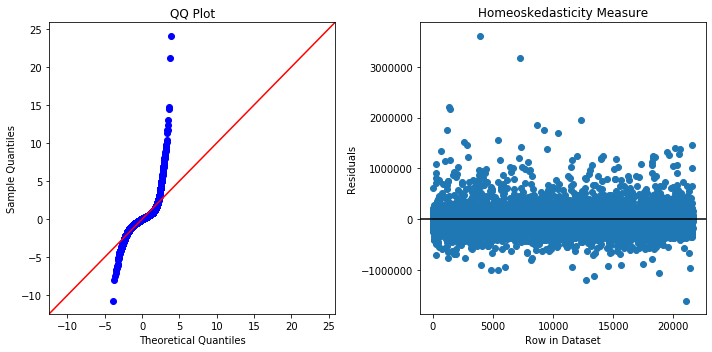

In [353]:
model_measures(raw_model)

For a raw model, an R^2 value of 0.83 is fantastic! We will be refining and perfecting our model to get to an even better value for our R^2.

From the above visualizations of our model performance, we can see that while we have relative homoskedasticity, our QQ plot leaves much to be desired. We can see that there are many outliers towards the upper bounds, so dealing with these outliers will give us a tighter model. 

# Section 4: Refined Modeling

## Outlier Removal

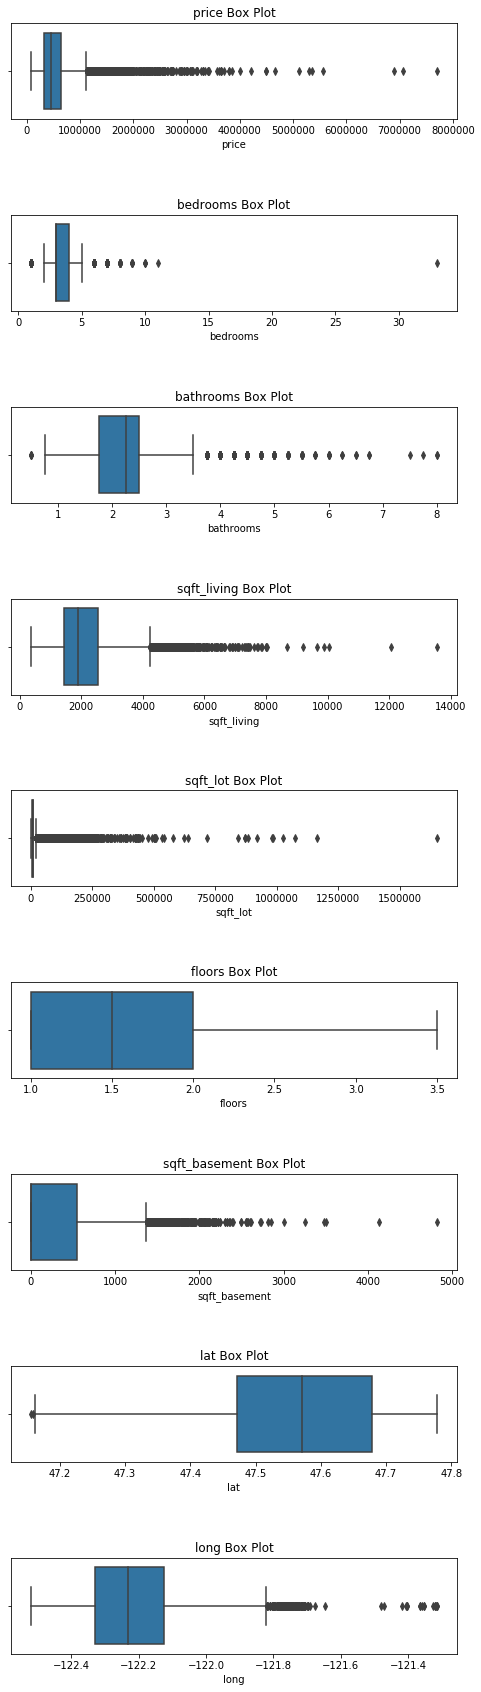

In [354]:
#defining columns that could have outliers, all that are not categorical
outlier_cols = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
               'floors', 'sqft_basement', 'lat', 'long']
fig, axes = plt.subplots(nrows = 9, ncols = 1, figsize = (8, 30))

for i, col in enumerate(outlier_cols):
        sns.boxplot(df_ohe[col], ax = axes[i]).set_title(col + ' Box Plot')
plt.subplots_adjust(hspace = 1)

From these visualizations, the following columns definitely have outliers:
- Price
- Bedrooms
- Bathrooms
- Sqft_living
- Sqft_lot
- Sqft_basement

    

We will keep latitude and longitude as they are, because having outliers in these columns is acceptable, since someone may have a property in the less populated parts of kings county, and this may affect home prices drastically. 

### Using Z-Scores to Remove Outliers

In [355]:
# first to define a function that will find outliers in a column, given
# a column and a threshold to eliminate outliers on. 
def z_score_outliers(col, threshold = 3):
    
    z_scores = np.abs(stats.zscore(df_ohe[col]))
    z_scores = pd.Series(z_scores, index = df_ohe[col].index)
    
    indexed_outliers = z_scores > threshold
    
    return indexed_outliers
    

In [356]:
to_be_cleaned = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'
                , 'sqft_basement']
price_outliers = z_score_outliers('price')
bedrooms_outliers = z_score_outliers('bedrooms')
bathrooms_outliers = z_score_outliers('bathrooms')
sqft_living_outliers = z_score_outliers('sqft_living')
sqft_lot_outliers = z_score_outliers('sqft_lot')
sqft_basement_outliers = z_score_outliers('sqft_basement')


In [357]:
#making a new dataframe to remove outliers from so that we may compare
#removal methods later

df_z_cleaned = df_ohe.copy()

#removing each column's outliers one by one

price_removed = df_z_cleaned[~price_outliers]
bedrooms_removed = price_removed[~bedrooms_outliers]
bathrooms_removed = bedrooms_removed[~bathrooms_outliers]
sqft_living_removed = bathrooms_removed[~sqft_living_outliers]
sqft_lot_removed = sqft_living_removed[~sqft_lot_outliers]
sqft_basement_removed = sqft_lot_removed[~sqft_basement_outliers]

#renaming our fully cleaned dataframe

df_z_cleaned = sqft_basement_removed

len(df_ohe) - len(df_z_cleaned)




/Users/LilBro/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/Users/LilBro/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/LilBro/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/Users/LilBro/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/LilBro/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindex

1086

By using the z-score method of outlier removal, we have removed 1086 rows from our dataset. 

### Using IQR to remove outliers

In [358]:
#defining a function to identify outliers, which takes a column of data

def iqr_outliers(col):
    
    details = df_ohe[col].describe()
    
    inter = (details['75%']) - (details['25%'])
    threshold = 1.5 * inter
    
    indexed_outliers = ((df_ohe[col] < details['25%'] - threshold) | 
    (df_ohe[col] > details['75%'] + threshold))
    
    return indexed_outliers

In [359]:
price_outliers = iqr_outliers('price')
bedrooms_outliers = iqr_outliers('bedrooms')
bathrooms_outliers = iqr_outliers('bathrooms')
sqft_living_outliers = iqr_outliers('sqft_living')
sqft_lot_outliers = iqr_outliers('sqft_lot')
sqft_basement_outliers = iqr_outliers('sqft_basement')

In [360]:
#making a new dataframe to remove outliers from so that we may compare
#removal methods later

df_iqr_cleaned = df_ohe.copy()

#removing each column's outliers one by one

price_removed = df_z_cleaned[~price_outliers]
bedrooms_removed = price_removed[~bedrooms_outliers]
bathrooms_removed = bedrooms_removed[~bathrooms_outliers]
sqft_living_removed = bathrooms_removed[~sqft_living_outliers]
sqft_lot_removed = sqft_living_removed[~sqft_lot_outliers]
sqft_basement_removed = sqft_lot_removed[~sqft_basement_outliers]

#renaming our fully cleaned dataframe

df_iqr_cleaned = sqft_basement_removed

print(len(df_ohe) - len(df_iqr_cleaned))


4084


/Users/LilBro/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/LilBro/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/Users/LilBro/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/LilBro/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/Users/LilBro/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame 

By using the IQR method of outlier removal, we have removed 4084 rows from our data! This is almost four times as much as using the z-score method. 

### Comparing Outlier Removal Methods

In [361]:
#using the same model as used in our raw model, only now without outliers.
#we keep the dropped columns identified in our multicollinearity check

z_model = model_maker(df_ohe = df_z_cleaned, drop_cols = ['yr_built', 'sqft_above', 'sqft_living15', 'sqft_lot15'])
iqr_model = model_maker(df_ohe = df_iqr_cleaned, drop_cols = ['yr_built', 'sqft_above', 'sqft_living15', 'sqft_lot15'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     1102.
Date:                Wed, 02 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:55:14   Log-Likelihood:            -2.6539e+05
No. Observations:               20511   AIC:                         5.310e+05
Df Residuals:                   20414   BIC:                         5.317e+05
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.444e+07   2.69e+06     -5.379      0.000   -1.97e+07   -9.18e+06
bedrooms               -2468.2833   1108.448     -2.227      0.026   -4640.930    -295.636
bathrooms               1.929e+04   1797.445     10.731      0.000    1.58e+04    2.28e+04
sqft_living              135.7308      2.051     66.181      0.000     131.711     139.751
sqft_lot                   0.6533      0.062     10.539      0.000       0.532       0.775
floors                 -2.543e+04   2068.258    -12.296      0.000   -2.95e+04   -2.14e+04
waterfront              2.393e+05   1.41e+04     16.954      0.000    2.12e+05    2.67e+05
sqft_basement            -45.6946      2.538    -18.001      0.000     -50.670     -40.719
lat                     1.195e+05   4.16e+04      2.871      0.004    3.79e+04    2.01e+05
long                   -1.359e+05   3.02e+04     -4.505      0.000   -1.95e+05   -7.68e+04
yrs_since_construction   229.7547     41.083      5.593      0.000     149.230     310.280
view_00                -2.996e+06   5.37e+05     -5.579      0.000   -4.05e+06   -1.94e+06
view_10                -2.917e+06   5.37e+05     -5.432      0.000   -3.97e+06   -1.86e+06
view_20                -2.921e+06   5.37e+05     -5.439      0.000   -3.97e+06   -1.87e+06
view_30                -2.854e+06   5.37e+05     -5.314      0.000   -3.91e+06    -1.8e+06
view_40                -2.756e+06   5.37e+05     -5.131      0.000   -3.81e+06    -1.7e+06
condition_1            -2.961e+06   5.37e+05     -5.510      0.000   -4.01e+06   -1.91e+06
condition_2            -2.907e+06   5.37e+05     -5.412      0.000   -3.96e+06   -1.85e+06
condition_3            -2.885e+06   5.37e+05     -5.372      0.000   -3.94e+06   -1.83e+06
condition_4            -2.865e+06   5.37e+05     -5.335      0.000   -3.92e+06   -1.81e+06
condition_5            -2.827e+06   5.37e+05     -5.264      0.000   -3.88e+06   -1.77e+06
grade_10               -1.365e+06   2.69e+05     -5.077      0.000   -1.89e+06   -8.38e+05
grade_11               -1.259e+06   2.69e+05     -4.682      0.000   -1.79e+06   -7.32e+05
grade_12               -1.091e+06   2.69e+05     -4.048      0.000   -1.62e+06   -5.63e+05
grade_13                1.411e-07   2.62e-08      5.384      0.000    8.97e-08    1.93e-07
grade_3                -1.436e+06   2.84e+05     -5.061      0.000   -1.99e+06    -8.8e+05
grade_4                -1.562e+06   2.69e+05     -5.801      0.000   -2.09e+06   -1.03e+06
grade_5                -1.593e+06   2.69e+05     -5.931      0.000   -2.12e+06   -1.07e+06
grade_6                 -1.59e+06   2.69e+05     -5.916      0.000   -2.12e+06   -1.06e+06
grade_7                -1.573e+06   2.69e+05     -5.852      0.000    -2.1e+06   -1.05e+06
grade_8                -1.532e+06   2.69e+05     -5.700      0.000   -2.06e+06  

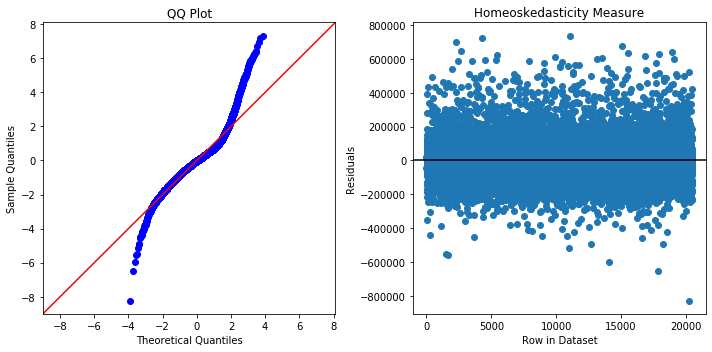

In [362]:
model_measures(z_model)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     953.5
Date:                Wed, 02 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:55:14   Log-Likelihood:            -2.2255e+05
No. Observations:               17513   AIC:                         4.453e+05
Df Residuals:                   17418   BIC:                         4.460e+05
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -5.291e+06    2.6e+06     -2.035      0.042   -1.04e+07   -1.95e+05
bedrooms               -1291.7631   1037.775     -1.245      0.213   -3325.906     742.380
bathrooms               1.358e+04   1612.199      8.425      0.000    1.04e+04    1.67e+04
sqft_living              129.2690      1.888     68.483      0.000     125.569     132.969
sqft_lot                   1.5999      0.248      6.460      0.000       1.115       2.085
floors                 -2.081e+04   1870.020    -11.129      0.000   -2.45e+04   -1.71e+04
waterfront              1.817e+05   1.99e+04      9.127      0.000    1.43e+05    2.21e+05
sqft_basement            -45.1480      2.378    -18.982      0.000     -49.810     -40.486
lat                     3439.3033   3.88e+04      0.089      0.929   -7.26e+04    7.95e+04
long                   -6.785e+04      3e+04     -2.263      0.024   -1.27e+05   -9080.735
yrs_since_construction   265.8627     36.108      7.363      0.000     195.087     336.638
view_00                -1.144e+06    5.2e+05     -2.201      0.028   -2.16e+06   -1.25e+05
view_10                -1.079e+06    5.2e+05     -2.075      0.038    -2.1e+06   -5.99e+04
view_20                -1.079e+06    5.2e+05     -2.075      0.038    -2.1e+06   -5.96e+04
view_30                -1.046e+06    5.2e+05     -2.011      0.044   -2.07e+06   -2.66e+04
view_40                -9.429e+05    5.2e+05     -1.813      0.070   -1.96e+06    7.64e+04
condition_1            -1.152e+06    5.2e+05     -2.214      0.027   -2.17e+06   -1.32e+05
condition_2            -1.081e+06    5.2e+05     -2.078      0.038    -2.1e+06   -6.12e+04
condition_3            -1.043e+06    5.2e+05     -2.005      0.045   -2.06e+06   -2.33e+04
condition_4            -1.024e+06    5.2e+05     -1.970      0.049   -2.04e+06   -5087.038
condition_5            -9.918e+05    5.2e+05     -1.907      0.056   -2.01e+06    2.74e+04
grade_10               -5.685e+05   3.25e+05     -1.749      0.080   -1.21e+06    6.87e+04
grade_11               -4.803e+05   3.25e+05     -1.476      0.140   -1.12e+06    1.58e+05
grade_12               -5.679e-08   2.82e-08     -2.016      0.044   -1.12e-07   -1.58e-09
grade_13                3.891e-09   1.93e-09      2.015      0.044    1.06e-10    7.68e-09
grade_3                 4.554e-08   2.28e-08      2.000      0.045    9.19e-10    9.02e-08
grade_4                -7.507e+05   3.25e+05     -2.306      0.021   -1.39e+06   -1.13e+05
grade_5                -7.476e+05   3.25e+05     -2.302      0.021   -1.38e+06   -1.11e+05
grade_6                -7.421e+05   3.25e+05     -2.283      0.022   -1.38e+06   -1.05e+05
grade_7                -7.188e+05   3.25e+05     -2.212      0.027   -1.36e+06   -8.17e+04
grade_8                -6.778e+05   3.25e+05     -2.085      0.037   -1.32e+06  

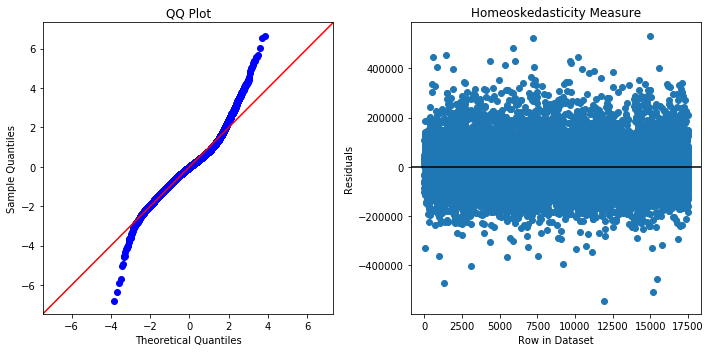

In [363]:
model_measures(iqr_model)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     1110.
Date:                Wed, 02 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:55:15   Log-Likelihood:            -2.8803e+05
No. Observations:               21597   AIC:                         5.763e+05
Df Residuals:                   21499   BIC:                         5.770e+05
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -2.364e+07   3.82e+06     -6.194      0.000   -3.11e+07   -1.62e+07
bedrooms               -1.201e+04   1467.884     -8.181      0.000   -1.49e+04   -9131.408
bathrooms               2.167e+04   2470.284      8.770      0.000    1.68e+04    2.65e+04
sqft_living              173.7504      2.722     63.830      0.000     168.415     179.086
sqft_lot                   0.1948      0.027      7.121      0.000       0.141       0.248
floors                 -3.323e+04   2942.651    -11.292      0.000    -3.9e+04   -2.75e+04
waterfront              6.026e+05   1.55e+04     38.901      0.000    5.72e+05    6.33e+05
sqft_basement            -52.4772      3.390    -15.480      0.000     -59.122     -45.832
lat                     2.268e+05   5.93e+04      3.822      0.000     1.1e+05    3.43e+05
long                   -2.081e+05   4.26e+04     -4.886      0.000   -2.92e+05   -1.25e+05
yrs_since_construction    70.6882     59.107      1.196      0.232     -45.166     186.542
view_00                -4.856e+06   7.63e+05     -6.361      0.000   -6.35e+06   -3.36e+06
view_10                -4.764e+06   7.63e+05     -6.240      0.000   -6.26e+06   -3.27e+06
view_20                -4.782e+06   7.63e+05     -6.264      0.000   -6.28e+06   -3.29e+06
view_30                -4.694e+06   7.63e+05     -6.149      0.000   -6.19e+06    -3.2e+06
view_40                -4.547e+06   7.64e+05     -5.956      0.000   -6.04e+06   -3.05e+06
condition_1            -4.822e+06   7.64e+05     -6.313      0.000   -6.32e+06   -3.32e+06
condition_2            -4.737e+06   7.64e+05     -6.204      0.000   -6.23e+06   -3.24e+06
condition_3            -4.726e+06   7.63e+05     -6.191      0.000   -6.22e+06   -3.23e+06
condition_4            -4.702e+06   7.63e+05     -6.159      0.000    -6.2e+06   -3.21e+06
condition_5            -4.657e+06   7.63e+05     -6.100      0.000   -6.15e+06   -3.16e+06
grade_10               -2.268e+06   3.47e+05     -6.528      0.000   -2.95e+06   -1.59e+06
grade_11               -2.072e+06   3.48e+05     -5.960      0.000   -2.75e+06   -1.39e+06
grade_12               -1.667e+06   3.48e+05     -4.798      0.000   -2.35e+06   -9.86e+05
grade_13               -5.653e+05    3.5e+05     -1.617      0.106   -1.25e+06     1.2e+05
grade_3                -2.324e+06   3.73e+05     -6.227      0.000   -3.06e+06   -1.59e+06
grade_4                -2.439e+06   3.48e+05     -7.006      0.000   -3.12e+06   -1.76e+06
grade_5                -2.481e+06   3.47e+05     -7.149      0.000   -3.16e+06    -1.8e+06
grade_6                -2.487e+06   3.47e+05     -7.162      0.000   -3.17e+06   -1.81e+06
grade_7                -2.487e+06   3.47e+05     -7.160      0.000   -3.17e+06   -1.81e+06
grade_8                -2.464e+06   3.47e+05     -7.091      0.000   -3.14e+06  

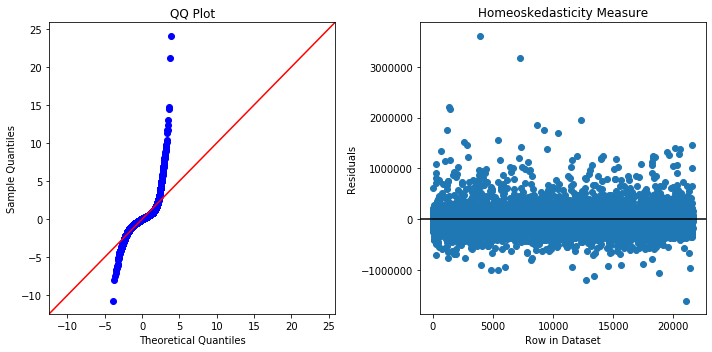

In [364]:
model_measures(raw_model)

#### Observations
- While IQR outlier removal handles over 4,000 rows of data, z_score removal handles only over 1,000. We would expect that with more data removal, the R^2 value would increase, as the datasets move to more normal distributions. However, our z-score cleaned data acheived a higher R^2 than the IQR cleaned data. Therefore, we will be continuing our refinement with df_z_cleaned, because this has both a superior R^2 and contains more data than df_iqr_cleaned.

In [365]:
df_clean = df_z_cleaned

## Normality Transformations

The most common type of normality transformation is a logarithmic transformation, which normalizes data by reducing to the logarithmic scale. However, there are other methods to acheive normality in our data that we can use, such as the Box Cox transformation. This method of transformation is automated through scipy.stats, and documentation can be found here. We will be using both logarithmic and Box Cox transformations on our data columns and deciding which lend theirselves better to our model. 

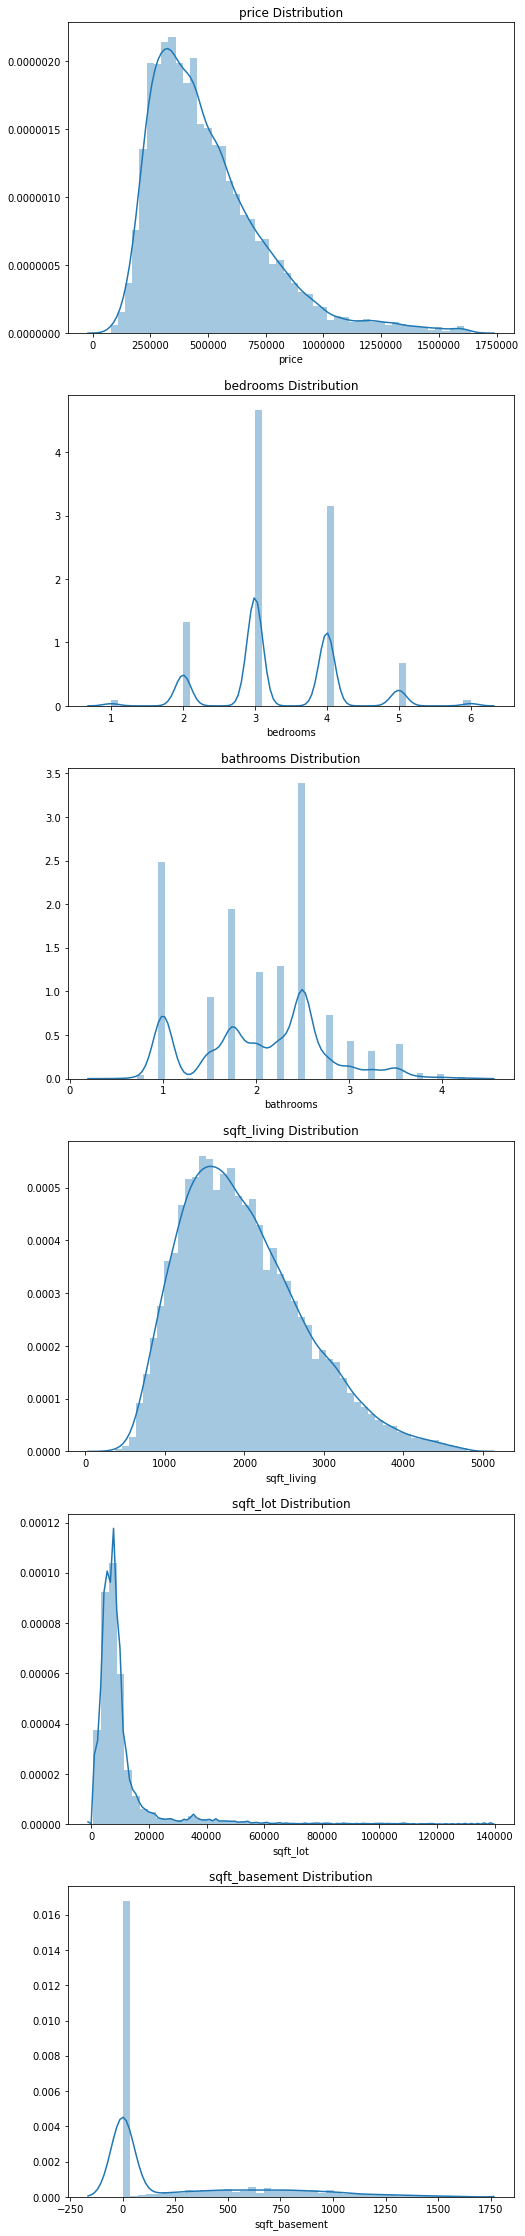

In [366]:
# First, we need to visualize the distributions of our columns. 


fig, axes = plt.subplots(ncols = 1, nrows = len(to_be_cleaned), figsize = (8, 40))
for i, col in enumerate(to_be_cleaned):
    sns.distplot(df_clean[col], ax = axes[i]).set_title(col + ' Distribution')

The following columns follow a relatively normal distribution and will not be transformed for normality:
- Bedrooms



The following are skewed and will be transformed using both a logarithmic transformation and Box-Cox transformation:
- Price
- Sqft_living
- sqft_lot

The following do not follow a normal distribution, and should therefore undergo a Box-Cox transformation:
- Bathrooms
- Sqft_basement


### Performing Logarithmic Transformation


In [367]:
log_cols = ['price', 'sqft_living', 'sqft_lot']

for col in log_cols:
    df_logged = df_clean.copy()
    df_logged[col] = df_logged[col].map(lambda x: np.log(x)) 

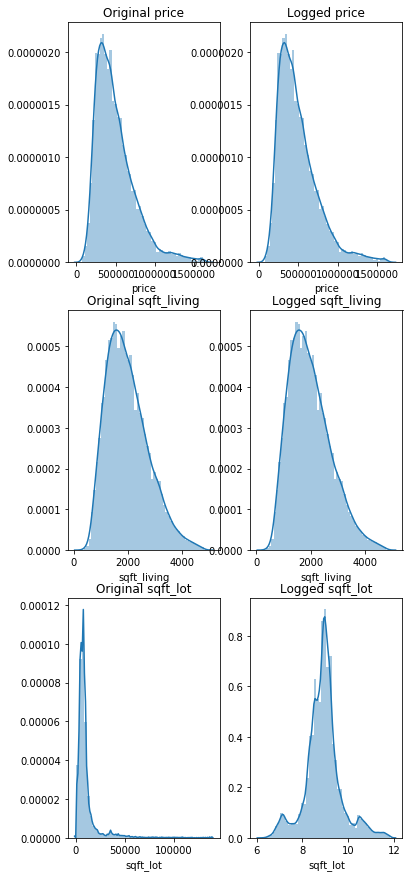

In [368]:
fig, axes = plt.subplots(nrows = len(log_cols), ncols = 2, figsize = (6, 15))
for i, col in enumerate(log_cols):
    sns.distplot(df_clean[col], ax = axes[i][0]).set_title("Original " +col)
    sns.distplot(df_logged[col], ax = axes[i][1]).set_title('Logged ' + col)

The most successful application of our log transformation was with our 'sqft_lot' column, which has drastically changed for the better in regard to normality. Our other transformed columns have also improved, but are still experiencing skewness. We will see if the Box-Cox transformation addresses this weakness of a log transformation. 

### Box-Cox Transformation

It's important to note that box cox transformations cannot be used on values less than or equal to zero. Because of this, we must exclude our 'sqft_basement' column from this transformation due to the high number of occurrences of zero. 

In [369]:
#import the Box-Cox function

from numpy import exp
from scipy.stats import boxcox


bxcx_cols = ['price', 'sqft_living', 'sqft_lot', 'bathrooms']
df_boxed = df_clean.copy()

for col in bxcx_cols:
    
    #apply our Box-Cox transformation
    
    df_boxed[col] = boxcox(df_boxed[col], 0)

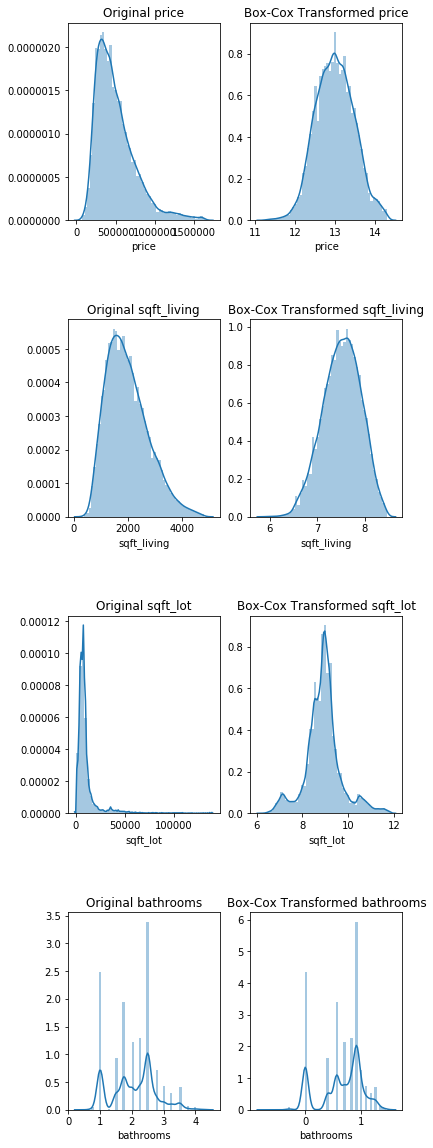

In [370]:
fig, axes = plt.subplots(ncols = 2, nrows = len(bxcx_cols), figsize = (6, 20))
for i, col in enumerate(bxcx_cols):
    sns.distplot(df_clean[col], ax = axes[i][0]).set_title("Original " +col)
    sns.distplot(df_boxed[col], ax = axes[i][1]).set_title('Box-Cox Transformed '+col)
    plt.subplots_adjust(hspace = 0.5)

By using the Box-Cox transformation method, our distributions have come out with a more normal distribution than when we used a logarithmic transformation. This is because the box-cox transformation automates selecting a transformation that best approaches normality in our data. This is why the logarithmic transformation and Box-Cox transformation on 'sqft_lot' are identical; both methods were the same. It's important to note that the transformations on 'bathrooms' were less successful, most likely due to the low amount of possibile records of this column, limiting how well we may transform on this small scale. 

In [371]:
df_transformed = df_boxed

## Model Construction

In [372]:
transformed_model = model_maker(df_transformed, drop_cols = ['yr_built', 'sqft_above', 'sqft_living15', 'sqft_lot15'])

## Model Evaluation

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     1337.
Date:                Wed, 02 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:55:20   Log-Likelihood:                 6439.3
No. Observations:               20511   AIC:                        -1.268e+04
Df Residuals:                   20414   BIC:                        -1.192e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -45.9401      4.716     -9.742      0.000     -55.183     -36.697
bedrooms                  -0.0093      0.002     -4.749      0.000      -0.013      -0.005
bathrooms                  0.0536      0.006      9.064      0.000       0.042       0.065
sqft_living                0.4910      0.007     67.009      0.000       0.477       0.505
sqft_lot                   0.0620      0.002     25.183      0.000       0.057       0.067
floors                    -0.0207      0.004     -5.451      0.000      -0.028      -0.013
waterfront                 0.4031      0.025     16.265      0.000       0.355       0.452
sqft_basement          -7.984e-05   4.49e-06    -17.786      0.000   -8.86e-05    -7.1e-05
lat                        0.4710      0.073      6.443      0.000       0.328       0.614
long                      -0.4596      0.053     -8.679      0.000      -0.563      -0.356
yrs_since_construction  2.019e-05   7.39e-05      0.273      0.785      -0.000       0.000
view_00                   -9.3420      0.943     -9.906      0.000     -11.190      -7.494
view_10                   -9.2106      0.943     -9.766      0.000     -11.059      -7.362
view_20                   -9.2150      0.943     -9.771      0.000     -11.063      -7.366
view_30                   -9.1394      0.943     -9.691      0.000     -10.988      -7.291
view_40                   -9.0331      0.943     -9.576      0.000     -10.882      -7.184
condition_1               -9.3904      0.944     -9.951      0.000     -11.240      -7.541
condition_2               -9.2676      0.943     -9.825      0.000     -11.116      -7.419
condition_3               -9.1384      0.943     -9.689      0.000     -10.987      -7.290
condition_4               -9.1031      0.943     -9.653      0.000     -10.952      -7.255
condition_5               -9.0406      0.943     -9.587      0.000     -10.889      -7.192
grade_10                  -4.4705      0.472     -9.469      0.000      -5.396      -3.545
grade_11                  -4.3641      0.472     -9.241      0.000      -5.290      -3.438
grade_12                  -4.2882      0.473     -9.062      0.000      -5.216      -3.361
grade_13                2.618e-13    2.7e-14      9.710      0.000    2.09e-13    3.15e-13
grade_3                   -4.2514      0.498     -8.530      0.000      -5.228      -3.275
grade_4                   -4.8368      0.473    -10.231      0.000      -5.763      -3.910
grade_5                   -4.8970      0.472    -10.385      0.000      -5.821      -3.973
grade_6                   -4.8395      0.472    -10.257      0.000      -5.764      -3.915
grade_7                   -4.7710      0.472    -10.109      0.000      -5.696      -3.846
grade_8                   -4.6749      0.472     -9.903      0.000      -5.600  

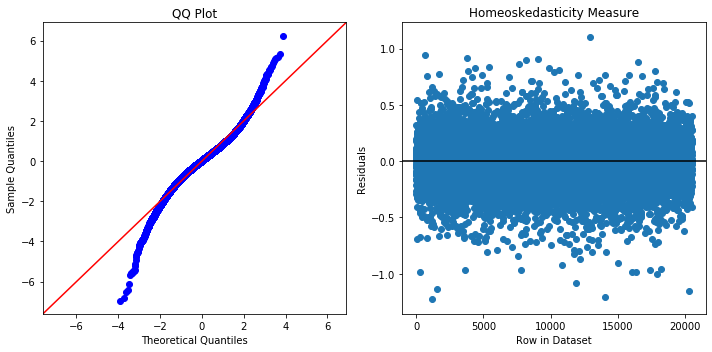

In [373]:
model_measures(transformed_model)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     1102.
Date:                Wed, 02 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:55:20   Log-Likelihood:            -2.6539e+05
No. Observations:               20511   AIC:                         5.310e+05
Df Residuals:                   20414   BIC:                         5.317e+05
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.444e+07   2.69e+06     -5.379      0.000   -1.97e+07   -9.18e+06
bedrooms               -2468.2833   1108.448     -2.227      0.026   -4640.930    -295.636
bathrooms               1.929e+04   1797.445     10.731      0.000    1.58e+04    2.28e+04
sqft_living              135.7308      2.051     66.181      0.000     131.711     139.751
sqft_lot                   0.6533      0.062     10.539      0.000       0.532       0.775
floors                 -2.543e+04   2068.258    -12.296      0.000   -2.95e+04   -2.14e+04
waterfront              2.393e+05   1.41e+04     16.954      0.000    2.12e+05    2.67e+05
sqft_basement            -45.6946      2.538    -18.001      0.000     -50.670     -40.719
lat                     1.195e+05   4.16e+04      2.871      0.004    3.79e+04    2.01e+05
long                   -1.359e+05   3.02e+04     -4.505      0.000   -1.95e+05   -7.68e+04
yrs_since_construction   229.7547     41.083      5.593      0.000     149.230     310.280
view_00                -2.996e+06   5.37e+05     -5.579      0.000   -4.05e+06   -1.94e+06
view_10                -2.917e+06   5.37e+05     -5.432      0.000   -3.97e+06   -1.86e+06
view_20                -2.921e+06   5.37e+05     -5.439      0.000   -3.97e+06   -1.87e+06
view_30                -2.854e+06   5.37e+05     -5.314      0.000   -3.91e+06    -1.8e+06
view_40                -2.756e+06   5.37e+05     -5.131      0.000   -3.81e+06    -1.7e+06
condition_1            -2.961e+06   5.37e+05     -5.510      0.000   -4.01e+06   -1.91e+06
condition_2            -2.907e+06   5.37e+05     -5.412      0.000   -3.96e+06   -1.85e+06
condition_3            -2.885e+06   5.37e+05     -5.372      0.000   -3.94e+06   -1.83e+06
condition_4            -2.865e+06   5.37e+05     -5.335      0.000   -3.92e+06   -1.81e+06
condition_5            -2.827e+06   5.37e+05     -5.264      0.000   -3.88e+06   -1.77e+06
grade_10               -1.365e+06   2.69e+05     -5.077      0.000   -1.89e+06   -8.38e+05
grade_11               -1.259e+06   2.69e+05     -4.682      0.000   -1.79e+06   -7.32e+05
grade_12               -1.091e+06   2.69e+05     -4.048      0.000   -1.62e+06   -5.63e+05
grade_13                1.411e-07   2.62e-08      5.384      0.000    8.97e-08    1.93e-07
grade_3                -1.436e+06   2.84e+05     -5.061      0.000   -1.99e+06    -8.8e+05
grade_4                -1.562e+06   2.69e+05     -5.801      0.000   -2.09e+06   -1.03e+06
grade_5                -1.593e+06   2.69e+05     -5.931      0.000   -2.12e+06   -1.07e+06
grade_6                 -1.59e+06   2.69e+05     -5.916      0.000   -2.12e+06   -1.06e+06
grade_7                -1.573e+06   2.69e+05     -5.852      0.000    -2.1e+06   -1.05e+06
grade_8                -1.532e+06   2.69e+05     -5.700      0.000   -2.06e+06  

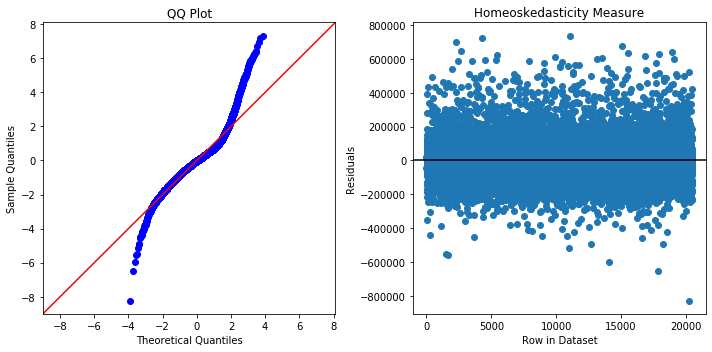

In [374]:
model_measures(z_model)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     1110.
Date:                Wed, 02 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:55:21   Log-Likelihood:            -2.8803e+05
No. Observations:               21597   AIC:                         5.763e+05
Df Residuals:                   21499   BIC:                         5.770e+05
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -2.364e+07   3.82e+06     -6.194      0.000   -3.11e+07   -1.62e+07
bedrooms               -1.201e+04   1467.884     -8.181      0.000   -1.49e+04   -9131.408
bathrooms               2.167e+04   2470.284      8.770      0.000    1.68e+04    2.65e+04
sqft_living              173.7504      2.722     63.830      0.000     168.415     179.086
sqft_lot                   0.1948      0.027      7.121      0.000       0.141       0.248
floors                 -3.323e+04   2942.651    -11.292      0.000    -3.9e+04   -2.75e+04
waterfront              6.026e+05   1.55e+04     38.901      0.000    5.72e+05    6.33e+05
sqft_basement            -52.4772      3.390    -15.480      0.000     -59.122     -45.832
lat                     2.268e+05   5.93e+04      3.822      0.000     1.1e+05    3.43e+05
long                   -2.081e+05   4.26e+04     -4.886      0.000   -2.92e+05   -1.25e+05
yrs_since_construction    70.6882     59.107      1.196      0.232     -45.166     186.542
view_00                -4.856e+06   7.63e+05     -6.361      0.000   -6.35e+06   -3.36e+06
view_10                -4.764e+06   7.63e+05     -6.240      0.000   -6.26e+06   -3.27e+06
view_20                -4.782e+06   7.63e+05     -6.264      0.000   -6.28e+06   -3.29e+06
view_30                -4.694e+06   7.63e+05     -6.149      0.000   -6.19e+06    -3.2e+06
view_40                -4.547e+06   7.64e+05     -5.956      0.000   -6.04e+06   -3.05e+06
condition_1            -4.822e+06   7.64e+05     -6.313      0.000   -6.32e+06   -3.32e+06
condition_2            -4.737e+06   7.64e+05     -6.204      0.000   -6.23e+06   -3.24e+06
condition_3            -4.726e+06   7.63e+05     -6.191      0.000   -6.22e+06   -3.23e+06
condition_4            -4.702e+06   7.63e+05     -6.159      0.000    -6.2e+06   -3.21e+06
condition_5            -4.657e+06   7.63e+05     -6.100      0.000   -6.15e+06   -3.16e+06
grade_10               -2.268e+06   3.47e+05     -6.528      0.000   -2.95e+06   -1.59e+06
grade_11               -2.072e+06   3.48e+05     -5.960      0.000   -2.75e+06   -1.39e+06
grade_12               -1.667e+06   3.48e+05     -4.798      0.000   -2.35e+06   -9.86e+05
grade_13               -5.653e+05    3.5e+05     -1.617      0.106   -1.25e+06     1.2e+05
grade_3                -2.324e+06   3.73e+05     -6.227      0.000   -3.06e+06   -1.59e+06
grade_4                -2.439e+06   3.48e+05     -7.006      0.000   -3.12e+06   -1.76e+06
grade_5                -2.481e+06   3.47e+05     -7.149      0.000   -3.16e+06    -1.8e+06
grade_6                -2.487e+06   3.47e+05     -7.162      0.000   -3.17e+06   -1.81e+06
grade_7                -2.487e+06   3.47e+05     -7.160      0.000   -3.17e+06   -1.81e+06
grade_8                -2.464e+06   3.47e+05     -7.091      0.000   -3.14e+06  

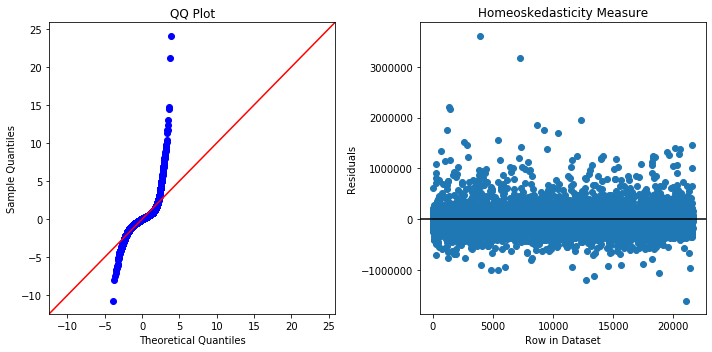

In [375]:
model_measures(raw_model)

## Model Training

In [376]:
import sklearn
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score

In [377]:
df_train, df_test = train_test_split(df_transformed)

model = model_maker(df_train, drop_cols = ['yr_built', 'sqft_above', 'sqft_living15', 'sqft_lot15'])
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     1015.
Date:                Wed, 02 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:55:22   Log-Likelihood:                 4873.9
No. Observations:               15383   AIC:                            -9554.
Df Residuals:                   15286   BIC:                            -8813.
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -45.5487      5.459     -8.343      0.000     -56.250     -34.848
bedrooms                  -0.0093      0.002     -4.133      0.000      -0.014      -0.005
bathrooms                  0.0529      0.007      7.748      0.000       0.040       0.066
sqft_living                0.4952      0.008     58.748      0.000       0.479       0.512
sqft_lot                   0.0610      0.003     21.399      0.000       0.055       0.067
floors                    -0.0214      0.004     -4.893      0.000      -0.030      -0.013
waterfront                 0.4107      0.027     14.965      0.000       0.357       0.464
sqft_basement          -8.441e-05   5.16e-06    -16.345      0.000   -9.45e-05   -7.43e-05
lat                        0.4660      0.084      5.538      0.000       0.301       0.631
long                      -0.4565      0.062     -7.403      0.000      -0.577      -0.336
yrs_since_construction -5.125e-06   8.54e-05     -0.060      0.952      -0.000       0.000
view_00                   -9.2698      1.092     -8.491      0.000     -11.410      -7.130
view_10                   -9.1351      1.092     -8.366      0.000     -11.276      -6.995
view_20                   -9.1356      1.092     -8.367      0.000     -11.276      -6.995
view_30                   -9.0557      1.092     -8.294      0.000     -11.196      -6.916
view_40                   -8.9525      1.092     -8.198      0.000     -11.093      -6.812
condition_1               -9.3150      1.093     -8.525      0.000     -11.457      -7.173
condition_2               -9.2027      1.092     -8.428      0.000     -11.343      -7.062
condition_3               -9.0554      1.092     -8.293      0.000     -11.196      -6.915
condition_4               -9.0195      1.092     -8.261      0.000     -11.160      -6.879
condition_5               -8.9562      1.092     -8.203      0.000     -11.096      -6.816
grade_10                  -4.4371      0.546     -8.119      0.000      -5.508      -3.366
grade_11                  -4.3275      0.546     -7.919      0.000      -5.399      -3.256
grade_12                  -4.2605      0.547     -7.784      0.000      -5.333      -3.188
grade_13                1.907e-13    2.3e-14      8.296      0.000    1.46e-13    2.36e-13
grade_3                   -4.2036      0.569     -7.386      0.000      -5.319      -3.088
grade_4                   -4.7872      0.547     -8.745      0.000      -5.860      -3.714
grade_5                   -4.8617      0.546     -8.906      0.000      -5.932      -3.792
grade_6                   -4.7959      0.546     -8.781      0.000      -5.866      -3.725
grade_7                   -4.7292      0.546     -8.657      0.000      -5.800      -3.658
grade_8                   -4.6357      0.546     -8.484      0.000      -5.707  

In [378]:
y_train_pred = model.predict(df_train)
y_test_pred = model.predict(df_test)

r2_train = r2_score(df_train[target], y_train_pred)
r2_test = r2_score(df_test[target], y_test_pred)

print(f"Training Score Acheived: {r2_train}")
print(f"Testing Score Acheived: {r2_test}")

Training Score Acheived: 0.8643838187111998
Testing Score Acheived: 0.8571590369596374


# Section 5: Model Simplification

## Why Simplify?

## Model Construction

## Model Evaluation